# What are the busiest times of the year to visit Seattle? By how much do prices spike?

# 1. Gather

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
# Load in calendar data.
calendar_df = pd.read_csv('calendar.csv',sep=',')

# 2. Assess

In [3]:
# The number of rows and columns of calendar data
calendar_df.shape

(1393570, 4)

In [4]:
# The columns information of calendar data
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
listing_id    1393570 non-null int64
date          1393570 non-null object
available     1393570 non-null object
price         934542 non-null object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


In [5]:
# Check if there's any duplicate records
calendar_df.duplicated().sum()

0

# 3. Clean and Analyze

## 3.1. Handle Inconsistent Data

In [6]:
# Change the type of price feature to float
calendar_df['price']= pd.to_numeric(calendar_df['price'].str.translate({ord(i): None for i in '$,'}))
calendar_df['price'].head()

0    85.0
1    85.0
2     NaN
3     NaN
4     NaN
Name: price, dtype: float64

In [7]:
# Change the type of date feature to date
calendar_df['date']= pd.to_datetime(calendar_df['date'],errors = 'ignore', format = '%Y-%m-%d')
calendar_df['date'].head()

0   2016-01-04
1   2016-01-05
2   2016-01-06
3   2016-01-07
4   2016-01-08
Name: date, dtype: datetime64[ns]

## 3.2. Handle Missing Data

In [8]:
# The average of missing data in each column
calendar_df.isnull().mean().sort_values(ascending=False)

price         0.32939
available     0.00000
date          0.00000
listing_id    0.00000
dtype: float64

In [9]:
# Records with missing price data
calendar_df[calendar_df['price'].isnull()].head()

,listing_id,date,available,price
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN
5,241032,2016-01-09,f,NaN
6,241032,2016-01-10,f,NaN


**Only price feature has null values, because of the absence of availability feature.**

In [10]:
# Drop rows wirh null values
calendar_df = calendar_df.dropna(subset=['price'], axis=0) 
calendar_df.shape

(934542, 4)

**Only data with availability feature is important for the price analysis, so rows with missing data are removed**

# 4. Model and Visualize

## 4.1 Process Data

In [11]:
# Convert 't' to 1 
calendar_df.loc[calendar_df['available']=='t','available']='1'
calendar_df['available'].value_counts()

1    934542
Name: available, dtype: int64

In [12]:
# Create new columns to split date to year, month, and day
calendar_df['year'] = calendar_df['date'].dt.year
calendar_df['month'] = calendar_df['date'].dt.month
calendar_df['day'] = calendar_df['date'].dt.day

In [13]:
calendar_df.head()

,listing_id,date,available,price,year,month,day
0,241032,2016-01-04,1,85.0,2016,1,4
1,241032,2016-01-05,1,85.0,2016,1,5
9,241032,2016-01-13,1,85.0,2016,1,13
10,241032,2016-01-14,1,85.0,2016,1,14
14,241032,2016-01-18,1,85.0,2016,1,18


In [14]:
# get months of each year
calendar_df.groupby(['year'])['month'].unique()

year
2016    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
2017                                        [1]
Name: month, dtype: object

**Only year 2016 data is considered, because it includes all months**

In [15]:
calendar_2016_df=calendar_df[calendar_df['year']==2016]
calendar_2016_df.head()

,listing_id,date,available,price,year,month,day
0,241032,2016-01-04,1,85.0,2016,1,4
1,241032,2016-01-05,1,85.0,2016,1,5
9,241032,2016-01-13,1,85.0,2016,1,13
10,241032,2016-01-14,1,85.0,2016,1,14
14,241032,2016-01-18,1,85.0,2016,1,18


## 4.2 Results

In [16]:
# this function is for plot graphs
def plot_graph(v,title):
    plt.figure(figsize=(8,3))
    plt.plot(v, 'o-')
    plt.title(title)
    plt.show()

### 4.2.1  Busiest months to visit Seattle

In [17]:
# Count of availability for each month
month_avb=calendar_2016_df.groupby(['month'])['available'].count()/calendar_2016_df.shape[0]

# Sort values in descending order
month_avb.sort_values(ascending=False)

month
12    0.093730
3     0.090368
10    0.088753
11    0.088045
5     0.086097
9     0.083164
6     0.083161
8     0.082196
4     0.081862
7     0.079908
2     0.078938
1     0.063777
Name: available, dtype: float64

In [18]:
# Get statistical information
month_avb.describe()

count    12.000000
mean      0.083333
std       0.007591
min       0.063777
25%       0.081373
50%       0.083163
75%       0.088222
max       0.093730
Name: available, dtype: float64

In [19]:
# Consider months with the average amount of available present over 0.0883 to be active (above 75% of data)
active_months_val=month_avb[month_avb>0.0883]

# Get names of active months
active_months=active_months_val.index.tolist()
active_months

[3, 10, 12]

In [20]:
# Consider months with the average amount of available present under 0.081 to be inactive (below 25% of data)
inactive_months_val=month_avb[month_avb<0.081]

# Get names of active months
inactive_months=inactive_months_val.index.tolist()
inactive_months

[1, 2, 7]

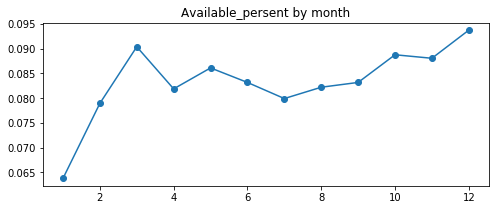

In [21]:
# Plot the available_persent by month
plot_graph(month_avb,'Available_persent by month')

**Based on the above graph,**
- December, March, and October are the busiest months of the year.
- January, February and July are the least.

### 4.2.2  Busiest Days to visit Seattle

#### 4.2.2.1  Active months

In [22]:
# Create a datframe with only active months
active_months_df=calendar_2016_df[calendar_2016_df['month'].isin(active_months)] 

# Count of availability for each day
active_months_avb_day=active_months_df.groupby(['day'])['available'].count()/active_months_df.shape[0]

# Sort values in descending order
active_months_avb_day.sort_values(ascending=False)

day
31    0.032738
30    0.032631
29    0.032620
28    0.032608
27    0.032604
26    0.032466
18    0.032414
20    0.032367
19    0.032359
17    0.032347
25    0.032343
23    0.032335
21    0.032332
16    0.032320
22    0.032316
24    0.032288
15    0.032249
14    0.032209
13    0.032166
6     0.032158
7     0.032111
8     0.032103
9     0.032095
11    0.032095
10    0.032087
12    0.032055
5     0.032012
4     0.032000
3     0.031894
2     0.031890
1     0.031791
Name: available, dtype: float64

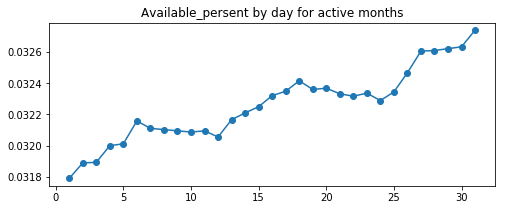

In [23]:
# Plot the available_persent by day
plot_graph(active_months_avb_day,'Available_persent by day for active months')

#### 4.2.2.3  Inactive months

In [24]:
# Create a datframe with only inactive months
inactive_months_df=calendar_2016_df[calendar_2016_df['month'].isin(inactive_months)] 

# Count of availability for each day
inactive_months_avb_day=inactive_months_df.groupby(['day'])['available'].count()/inactive_months_df.shape[0]

# Sort values in descending order
inactive_months_avb_day.sort_values(ascending=False)

day
26    0.035646
27    0.035535
25    0.035511
29    0.035429
24    0.035380
28    0.035351
21    0.035255
20    0.035230
19    0.035119
22    0.035119
23    0.035114
18    0.034810
17    0.034036
12    0.033717
11    0.033683
10    0.033576
13    0.033499
16    0.033427
15    0.033412
14    0.033388
9     0.032774
8     0.032319
7     0.032164
5     0.032106
6     0.031898
4     0.031415
3     0.023227
2     0.023198
31    0.023097
1     0.023034
30    0.022531
Name: available, dtype: float64

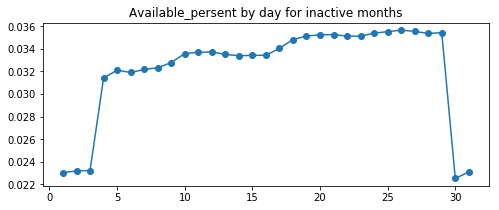

In [25]:
# Plot the available_persent by day
plot_graph(inactive_months_avb_day,'Available_persent by day for inactive months')

### 4.2.3  Price trends of months

In [26]:
# Average price per months
month_price=calendar_2016_df.groupby(['month'])['price'].mean()

# Sort values in descending order
month_price.sort_values(ascending=False)

month
7     152.094150
8     150.656594
6     147.473137
9     143.255949
5     139.538183
12    137.251835
10    137.031939
11    135.688738
4     135.097005
3     128.644488
2     124.293927
1     121.568409
Name: price, dtype: float64

In [27]:
# Get statistical information
month_price.describe()

count     12.000000
mean     137.716196
std        9.715239
min      121.568409
25%      133.483876
50%      137.141887
75%      144.310246
max      152.094150
Name: price, dtype: float64

In [28]:
# Consider months with avergae price over 147 to be expensive (above 75% of data)
high_price_months_val=month_price[month_price>147]

# Get names of high price months
high_price_months=high_price_months_val.index.tolist()
high_price_months

[6, 7, 8]

In [29]:
# Consider months with avergae price under 133 to be cheap (under 25% of data)
low_price_months_val=month_price[month_price<133]

# Get names of high price months
low_price_months=low_price_months_val.index.tolist()
low_price_months

[1, 2, 3]

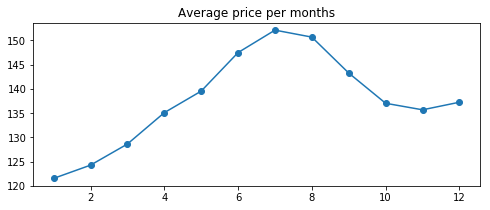

In [30]:
# Plot the average price per months
plot_graph(month_price,'Average price per months')

**Based on the above graph,**
- prices increase in summer season, mostly in June, July and August.
- They decrease in winter season in January, February, and March.

In [31]:
# Get monhts that are active and expensive
list(set(high_price_months) & set(active_months) )

[]

In [32]:
# Get monhts that are inactive and expensive
list(set(high_price_months) & set(inactive_months) )

[7]

In [33]:
# Get monhts that are active and cheap
list(set(low_price_months) & set(active_months) )

[3]

In [34]:
# Get monhts that are inactive and cheap
list(set(low_price_months) & set(inactive_months) )

[1, 2]

**In Conclusion,** January and February are less crowded and cheaper. 